# Testing Various Model Types - Proving Efficacy of BERT Embeddings on Subcellular Location Prediction

In [1]:
from Bio import SeqIO
import pandas as pd
import torch
from tape import ProteinBertModel, TAPETokenizer
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import torch
from tape import ProteinBertModel, TAPETokenizer

import numpy as np
import pandas as pd
import json

from sklearn.linear_model import LogisticRegression
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

Using TensorFlow backend.
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/thomaswaldschmid

### Data Loading

In [2]:
model = ProteinBertModel.from_pretrained('bert-base')
tokenizer = TAPETokenizer(vocab='iupac')

lookup_d = {}
seq_list = []
loc_list = []
count = 0
for record in SeqIO.parse("data/deeploc_data_1024.fasta", "fasta"):
    description = record.description
    seq = record.seq
    seq_list.append(len(str(seq)))
    count += 1
    desc_split = description.split(" ")
    loc_list.append(desc_split)
    #loc_list.append(desc_split[:len(desc_split)-2])
    if len(desc_split) == 3:
        ID = desc_split[0]
        label = desc_split[1]
        label = label[:len(label)-2]
        if label == "Cytoplasm-Nucleus":
            label = "Nucleus"
        lookup_d[ID] = label
    
    else:
        ID = desc_split[0]
        label = desc_split[1]
        label = label[:len(label)-2]
        if label == "Cytoplasm-Nucleus":
            label = "Nucleus"
        lookup_d[ID] = label

In [3]:
seq_df = pd.DataFrame(seq_list)
loc_df = pd.DataFrame(loc_list)
sub_cellular_df = pd.merge(left=loc_df, right=seq_df,how='inner',left_index=True,right_index=True)
#label_df=pd.DataFrame.from_dict(lookup_d,orient='index')
#print(loc_df.shape)
sub_cellular_df=sub_cellular_df.rename(columns= {'0_x':'ID', 1:'Location',2:'TBD','0_y':'Seq Length'})
seq_df.describe(percentiles=[.91, .95, .99])

,0
count,12704.000000
mean,418.507793
std,234.958061
min,40.000000
50%,389.000000
91%,781.000000
95%,873.000000
99%,988.970000
max,1024.000000


In [58]:
# sub_cellular_df.groupby('Location').mean()
#sub_cellular_df
#loc_df

In [5]:
train_arrays = np.load('data/output_deeploc_train.npz', allow_pickle=True)
valid_arrays = np.load('data/output_deeploc_valid.npz', allow_pickle=True)
test_arrays = np.load('data/output_deeploc_test.npz', allow_pickle=True)

In [6]:
id_dict = {'Cell.membrane': 0, 
 'Cytoplasm': 1, 
 'Endoplasmic.reticulum': 2, 
 'Golgi.apparatus': 3, 
 'Lysosome/Vacuole': 4,
 'Mitochondrion': 5, 
 'Nucleus': 6,
 'Peroxisome': 7, 
 'Plastid': 8,
 'Extracellular': 9}


def gen_df(df, label_list, arrays):
    l = list(arrays.keys())
    labels = []
    for a in l:
        d = arrays[a].item()['avg']
        append_df = pd.DataFrame(d)
        labels.append(lookup_d[a])
        df = df.append(append_df.transpose(), ignore_index=True)
    return df, labels

train_df, train_labels = gen_df(pd.DataFrame(), [], train_arrays)
valid_df, valid_labels = gen_df(pd.DataFrame(), [], valid_arrays)
test_df, test_labels = gen_df(pd.DataFrame(), [], test_arrays)

In [7]:
id_df=pd.DataFrame.from_dict(id_dict,orient='index')

In [11]:
#train_df.describe().T

In [12]:
id_df.rename(columns= {0:'Class'})

,Class
Cell.membrane,0
Cytoplasm,1
Endoplasmic.reticulum,2
Golgi.apparatus,3
Lysosome/Vacuole,4
Mitochondrion,5
Nucleus,6
Peroxisome,7
Plastid,8
Extracellular,9


In [13]:
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_labels = train_labels + valid_labels
train_y = [id_dict[label] for label in train_valid_labels]
test_y = [id_dict[label] for label in test_labels]

print(train_valid_df.shape)
#print(train_y)


(10222, 768)


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [37]:
parameters = [{
'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 
'C': [1,2,3,300,500],
'max_iter': [1000,100000]}]

In [ ]:
# Grid scores on development set:

# Best parameters set found on development set:

# {'C': 500, 'kernel': 'poly', 'max_iter': 100000}
# Grid best score:

# # 0.7248092349833692

In [ ]:

# clf = SVC(kernel='poly',C=500, max_iter=100000)

# XGBoost - Classifier 

In [16]:
d_train=xgb.DMatrix(train_valid_df, label=train_y)
d_test = xgb.DMatrix(test_df,label=test_y)

In [68]:
param = {
    'eta': 0.25, 
    'max_depth': 10,  
    'objective': 'multi:softprob',  
    'num_class': 10,
    'eval_metric': 'auc'} 

steps = 50  # The number of training iterations

In [69]:
model = xgb.train(param, d_train, steps)

In [70]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(d_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(test_y, best_preds, average='macro')))
print("Recall = {}".format(recall_score(test_y, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(test_y, best_preds)))

Precision = 0.5461920457389592
Recall = 0.46003058524426227
Accuracy = 0.6388436482084691


### Logistic Regression - ROC Curves - One vs. Rest Classifier

In [20]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


Automatically created module for IPython interactive environment


In [21]:
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_labels = train_labels + valid_labels

In [22]:
train_y = [id_dict[label] for label in train_valid_labels]
test_y = [id_dict[label] for label in test_labels]
#test_lab = [id_dict[label] for label in test_labels]

In [23]:
# Binarize the output for One Vs. Rest Classifiers
y_train = label_binarize(train_y, classes=[0, 1, 2,3,4,5,6,7,8,9])
y_test = label_binarize(test_y, classes=[0, 1, 2,3,4,5,6,7,8,9])
n_classes = y_test.shape[1]

In [24]:
clf = OneVsRestClassifier(LogisticRegression(solver='newton-cg',random_state=42,multi_class='multinomial'))
y_score = clf.fit(train_valid_df, y_train).decision_function(test_df)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



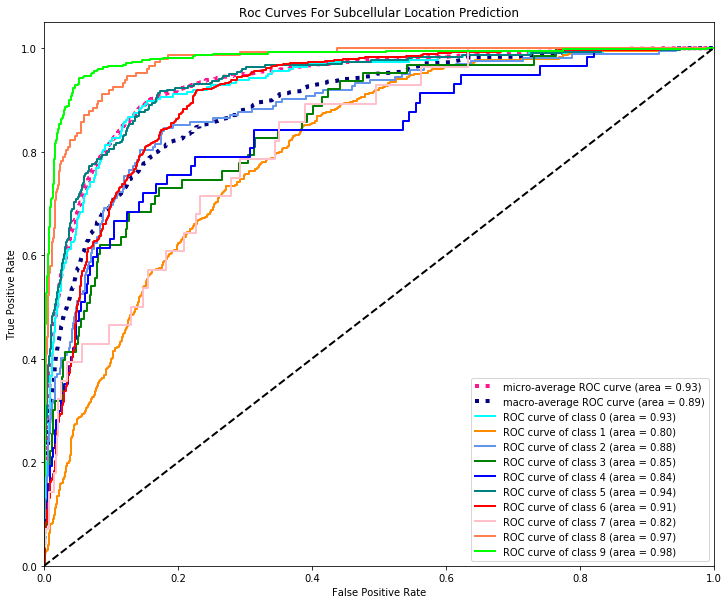

In [27]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','blue','teal','red','pink','coral','lime'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curves For Subcellular Location Prediction - Logistic')
plt.legend(loc="lower right")
plt.show()

# One vs. Rest Classifier using SCV

In [47]:
clf = OneVsRestClassifier(SVC(kernel='poly',C=500, max_iter=100000))
y_score = clf.fit(train_valid_df, y_train).decision_function(test_df)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thomaswaldschmidt/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thomaswaldschmi

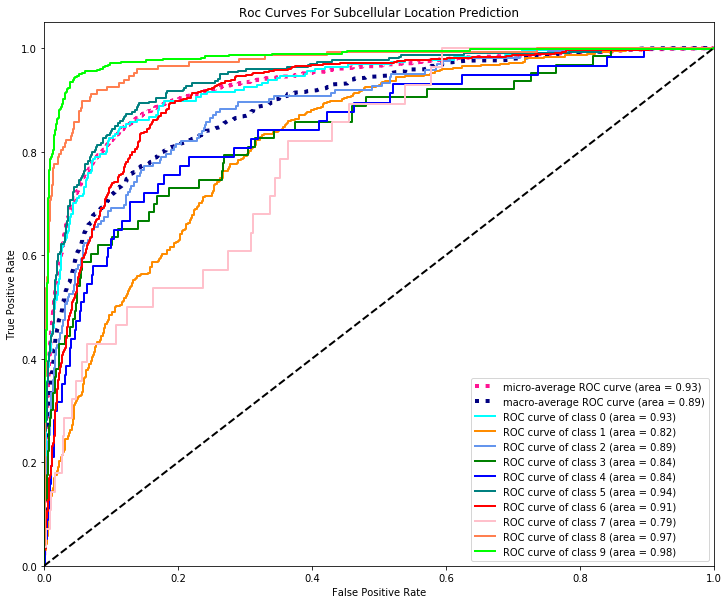

In [48]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','blue','teal','red','pink','coral','lime'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curves For Subcellular Location Prediction - SVM')
plt.legend(loc="lower right")
plt.show()

### Keras DNN

In [26]:
train_lab = [id_dict[label] for label in train_labels]
valid_lab = [id_dict[label] for label in valid_labels]
test_lab = [id_dict[label] for label in test_labels]

In [79]:
model = Sequential()
model.add(Dense(32, input_dim=768, activation='softmax'))
model.add(Dense(32, activation='softmax'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
history = model.fit(train_df, to_categorical(train_lab), 
          validation_data=(valid_df, to_categorical(valid_lab)),
          epochs=200, batch_size=64)

Train on 9220 samples, validate on 1002 samples
Epoch 1/200
9220/9220 [==============================] - 1s 133us/step - loss: 2.2197 - acc: 0.2502 - val_loss: 2.1492 - val_acc: 0.2844
Epoch 2/200
9220/9220 [==============================] - 0s 41us/step - loss: 2.0988 - acc: 0.2734 - val_loss: 2.0491 - val_acc: 0.2844
Epoch 3/200
9220/9220 [==============================] - 0s 44us/step - loss: 2.0094 - acc: 0.2734 - val_loss: 1.9603 - val_acc: 0.3603
Epoch 4/200
9220/9220 [==============================] - 0s 44us/step - loss: 1.9184 - acc: 0.4081 - val_loss: 1.8659 - val_acc: 0.3972
Epoch 5/200
9220/9220 [==============================] - 0s 39us/step - loss: 1.8253 - acc: 0.4132 - val_loss: 1.7772 - val_acc: 0.3992
Epoch 6/200
9220/9220 [==============================] - 0s 42us/step - loss: 1.7439 - acc: 0.4150 - val_loss: 1.7042 - val_acc: 0.3982
Epoch 7/200
9220/9220 [==============================] - 0s 44us/step - loss: 1.6846 - acc: 0.4146 - val_loss: 1.6639 - val_acc: 0.3992

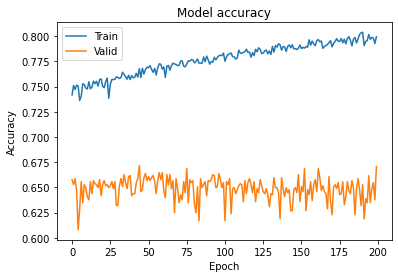

In [77]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [76]:
model.evaluate(test_df, to_categorical(test_lab))

2456/2456 [==============================] - 0s 24us/step


[1.3570286637408726, 0.617671009577835]